In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00


NSIDC Scene Retrieval Script Imports

In [ ]:
import base64
import itertools
import json
import math
import netrc
import ssl
import sys
import time
from urllib.parse import urlparse
from urllib.request import urlopen, Request, build_opener, HTTPCookieProcessor
from urllib.error import HTTPError, URLError
from getpass import getpass

CODE Imports

In [ ]:
from netCDF4 import Dataset
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import xarray as xr
from datetime import datetime
from osgeo import ogr
import shapely
from shapely.geometry import Polygon, Point
import xml.etree.ElementTree as ET
import scipy
from os import listdir
from os.path import isfile, join
import shutil

Code Associated with NSIDC Automated Scene Retrieval

In [ ]:
CMR_URL = 'https://cmr.earthdata.nasa.gov'
URS_URL = 'https://urs.earthdata.nasa.gov'
CMR_PAGE_SIZE = 2000
CMR_FILE_URL = ('{0}/search/granules.json?provider=NSIDC_ECS'
                '&sort_key[]=start_date&sort_key[]=producer_granule_id'
                '&scroll=true&page_size={1}'.format(CMR_URL, CMR_PAGE_SIZE))

def get_token(token=''):
    if not token:
        token = getpass('bearer token: ')
    return token

def get_login_credentials(token=''):
    """Get user credentials from .netrc or prompt for input."""
    credentials = None
    if token:
        return None, token

    try:
        info = netrc.netrc()
        username, account, password = info.authenticators(urlparse(URS_URL).hostname)
        if username == 'token':
            token = password
        else:
            credentials = '{0}:{1}'.format(username, password)
            credentials = base64.b64encode(credentials.encode('ascii')).decode('ascii')
    except Exception:
        username = None
        password = None

    if not username:
        username =  input('Earthdata username (or press Return to use a bearer token): ')
        if len(username):
            password = getpass('password: ')
            credentials = '{0}:{1}'.format(username, password)
            credentials = base64.b64encode(credentials.encode('ascii')).decode('ascii')
        else:
            token = get_token()

    return credentials, token

def build_version_query_params(version):
    desired_pad_length = 3
    if len(version) > desired_pad_length:
        print('Version string too long: "{0}"'.format(version))
        quit()

    version = str(int(version))  # Strip off any leading zeros
    query_params = ''

    while len(version) <= desired_pad_length:
        padded_version = version.zfill(desired_pad_length)
        query_params += '&version={0}'.format(padded_version)
        desired_pad_length -= 1
    return query_params

def filter_add_wildcards(filter):
    if not filter.startswith('*'):
        filter = '*' + filter
    if not filter.endswith('*'):
        filter = filter + '*'
    return filter

def build_filename_filter(filename_filter):
    filters = filename_filter.split(',')
    result = '&options[producer_granule_id][pattern]=true'
    for filter in filters:
        result += '&producer_granule_id[]=' + filter_add_wildcards(filter)
    return result

def build_cmr_query_url(short_name, version, time_start, time_end,
                        bounding_box=None, polygon=None,
                        filename_filter=None):
    params = '&short_name={0}'.format(short_name)
    params += build_version_query_params(version)
    params += '&temporal[]={0},{1}'.format(time_start, time_end)
    if polygon:
        params += '&polygon={0}'.format(polygon)
    elif bounding_box:
        params += '&bounding_box={0}'.format(bounding_box)
    if filename_filter:
        params += build_filename_filter(filename_filter)
    return CMR_FILE_URL + params

def get_speed(time_elapsed, chunk_size):
    if time_elapsed <= 0:
        return ''
    speed = chunk_size / time_elapsed
    if speed <= 0:
        speed = 1
    size_name = ('', 'k', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y')
    i = int(math.floor(math.log(speed, 1000)))
    p = math.pow(1000, i)
    return '{0:.1f}{1}B/s'.format(speed / p, size_name[i])

def output_progress(count, total, status='', bar_len=60):
    if total <= 0:
        return
    fraction = min(max(count / float(total), 0), 1)
    filled_len = int(round(bar_len * fraction))
    percents = int(round(100.0 * fraction))
    bar = '=' * filled_len + ' ' * (bar_len - filled_len)
    fmt = '  [{0}] {1:3d}%  {2}   '.format(bar, percents, status)
    print('\b' * (len(fmt) + 4), end='')  # clears the line
    sys.stdout.write(fmt)
    sys.stdout.flush()

def cmr_read_in_chunks(file_object, chunk_size=1024 * 1024):
    """Read a file in chunks using a generator. Default chunk size: 1Mb."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

def get_login_response(url, credentials, token):
    opener = build_opener(HTTPCookieProcessor())

    req = Request(url)
    if token:
        req.add_header('Authorization', 'Bearer {0}'.format(token))
    elif credentials:
        try:
            response = opener.open(req)
            # We have a redirect URL - try again with authorization.
            url = response.url
        except HTTPError:
            # No redirect - just try again with authorization.
            pass
        except Exception as e:
            print('Error{0}: {1}'.format(type(e), str(e)))
            sys.exit(1)

        req = Request(url)
        req.add_header('Authorization', 'Basic {0}'.format(credentials))

    try:
        response = opener.open(req)
    except HTTPError as e:
        err = 'HTTP error {0}, {1}'.format(e.code, e.reason)
        if 'Unauthorized' in e.reason:
            if token:
                err += ': Check your bearer token'
            else:
                err += ': Check your username and password'
        print(err)
        sys.exit(1)
    except Exception as e:
        print('Error{0}: {1}'.format(type(e), str(e)))
        sys.exit(1)

    return response

def cmr_download(urls, force=False, quiet=False, download_dir='./VIIRS_data'):
    """Download files from list of urls into specified directory."""
    if not urls:
        return

    # Create the directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    url_count = len(urls)
    if not quiet:
        print(f'Downloading {url_count} files to {download_dir}...')

    credentials = None
    token = None

    for index, url in enumerate(urls, start=1):
        if not credentials and not token:
            p = urlparse(url)
            if p.scheme == 'https':
                credentials, token = get_login_credentials()

        filename = os.path.join(download_dir, url.split('/')[-1])
        if not quiet:
            print('{0}/{1}: {2}'.format(str(index).zfill(len(str(url_count))),
                                        url_count, filename))

        try:
            response = get_login_response(url, credentials, token)
            length = int(response.headers['content-length'])
            try:
                if not force and length == os.path.getsize(filename):
                    if not quiet:
                        print('  File exists, skipping')
                    continue
            except OSError:
                pass
            count = 0
            chunk_size = min(max(length, 1), 1024 * 1024)
            max_chunks = int(math.ceil(length / chunk_size))
            time_initial = time.time()
            with open(filename, 'wb') as out_file:
                for data in cmr_read_in_chunks(response, chunk_size=chunk_size):
                    out_file.write(data)
                    if not quiet:
                        count = count + 1
                        time_elapsed = time.time() - time_initial
                        download_speed = get_speed(time_elapsed, count * chunk_size)
                        output_progress(count, max_chunks, status=download_speed)
            if not quiet:
                print()
        except HTTPError as e:
            print('HTTP error {0}, {1}'.format(e.code, e.reason))
        except URLError as e:
            print('URL error: {0}'.format(e.reason))
        except IOError:
            raise

def cmr_filter_urls(search_results):
    """Select only the desired data files from CMR response."""
    if 'feed' not in search_results or 'entry' not in search_results['feed']:
        return []

    entries = [e['links']
               for e in search_results['feed']['entry']
               if 'links' in e]
    # Flatten "entries" to a simple list of links
    links = list(itertools.chain(*entries))

    urls = []
    unique_filenames = set()
    for link in links:
        if 'href' not in link:
            # Exclude links with nothing to download
            continue
        if 'inherited' in link and link['inherited'] is True:
            # Why are we excluding these links?
            continue
        if 'rel' in link and 'data#' not in link['rel']:
            # Exclude links which are not classified by CMR as "data" or "metadata"
            continue

        if 'title' in link and 'opendap' in link['title'].lower():
            # Exclude OPeNDAP links--they are responsible for many duplicates
            # This is a hack; when the metadata is updated to properly identify
            # non-datapool links, we should be able to do this in a non-hack way
            continue

        filename = link['href'].split('/')[-1]
        if filename in unique_filenames:
            # Exclude links with duplicate filenames (they would overwrite)
            continue
        unique_filenames.add(filename)

        urls.append(link['href'])

    return urls

def cmr_search(short_name, version, time_start, time_end,
               bounding_box='', polygon='', filename_filter='', quiet=False):
    """Perform a scrolling CMR query for files matching input criteria."""
    cmr_query_url = build_cmr_query_url(short_name=short_name, version=version,
                                        time_start=time_start, time_end=time_end,
                                        bounding_box=bounding_box,
                                        polygon=polygon, filename_filter=filename_filter)
    if not quiet:
        print('Querying for data:\n\t{0}\n'.format(cmr_query_url))

    cmr_scroll_id = None
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    urls = []
    hits = 0
    while True:
        req = Request(cmr_query_url)
        if cmr_scroll_id:
            req.add_header('cmr-scroll-id', cmr_scroll_id)
        try:
            response = urlopen(req, context=ctx)
        except Exception as e:
            print('Error: ' + str(e))
            sys.exit(1)
        if not cmr_scroll_id:
            # Python 2 and 3 have different case for the http headers
            headers = {k.lower(): v for k, v in dict(response.info()).items()}
            cmr_scroll_id = headers['cmr-scroll-id']
            hits = int(headers['cmr-hits'])
            if not quiet:
                if hits > 0:
                    print('Found {0} matches.'.format(hits))
                else:
                    print('Found no matches.')
        search_page = response.read()
        search_page = json.loads(search_page.decode('utf-8'))
        url_scroll_results = cmr_filter_urls(search_page)
        if not url_scroll_results:
            break
        if not quiet and hits > CMR_PAGE_SIZE:
            print('.', end='')
            sys.stdout.flush()
        urls += url_scroll_results

    if not quiet and hits > CMR_PAGE_SIZE:
        print()
    return urls

def run_nsidc_download(short_name='VNP30', version='1', time_start='', time_end='', bounding_box='', polygon='', filename_filter='', token='', force=False, quiet=False):
    try:
        url_list = cmr_search(short_name, version, time_start, time_end,
                              bounding_box=bounding_box, polygon=polygon,
                              filename_filter=filename_filter, quiet=quiet)

        cmr_download(url_list, force=force, quiet=quiet)
    except KeyboardInterrupt:
        quit()

In [ ]:
sentinel_filepath = '/content/drive/MyDrive/Good-Data/Data/'
VIIRS_filepath = '/content/VIIRS_data/'
save_filepath = '/content/drive/MyDrive/Good-Data/'

In [ ]:
# create xarray dataset from Sentinel-1 .nc file
def load_Sentinel(file):
  os.environ['AI4ARCTIC_DATA'] = ''
  os.environ['AI4ARCTIC_ENV'] = ''
  Sentinel_data = xr.open_dataset(os.path.join(os.environ['AI4ARCTIC_DATA'], file))
  return Sentinel_data

# function to delete files because of storage issues associated with using Google Drive/CoLab
def delete_all_files_in_folder(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return

    # Iterate through the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file or link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory and all its contents
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

    print(f"All files in the folder '{folder_path}' have been deleted.")

In [ ]:
# I assessed VIIRS scenes one AI4Arctic file at a time because I needed to visually assess cloud cover.
# You could automate this because you don't have the same limitations
sentinel_filename = '20191008T125119_cis_prep.nc'

try:
  Sentinel_data = load_Sentinel(sentinel_filepath + sentinel_filename)
except:
  print("ERROR: there are multiple .nc files in this directory")

print(f'TRIAL FOR: {sentinel_filename}\n')

### Load the Sentinel-1 trial file ###
Sentinel_data = load_Sentinel(sentinel_filepath + sentinel_filename)
### Load the Sentinel-1 trial file ###

file_id = Sentinel_data.attrs['scene_id']
id = Sentinel_data.attrs['original_id']

# find the date and time of acquisition
date_Sentinel = id[17:21] + '-' + id[21:23] + '-' + id[23:25]
time_Sentinel = id[26:28] + ':' + id[28:30] + ':' + id[30:32]

end_date = int(id[23:25]) + 1
if len(str(end_date)) == 1:
  end_date = id[17:21] + '-' + id[21:23] + '-0' + str(end_date)
else:
  end_date = id[17:21] + '-' + id[21:23] + '-' + str(end_date)

print(end_date) # print end date to confirm that I haven't created an invalid date (e.g., 2018-01-32)

# find the latitude/longitude bounds
latitude_sentinel_1 = np.around(np.array(Sentinel_data.variables['sar_grid2d_latitude'][:,:]), decimals=5)
longitude_sentinel_1 = np.around(np.array(Sentinel_data.variables['sar_grid2d_longitude'][:,:]), decimals=5)
lat_bounds = (latitude_sentinel_1[0,0],latitude_sentinel_1[-1,0],latitude_sentinel_1[0,-1],latitude_sentinel_1[-1,-1])
lon_bounds = (longitude_sentinel_1[0,0],longitude_sentinel_1[-1,0],longitude_sentinel_1[0,-1],longitude_sentinel_1[-1,-1])

print("FIND VIIRS FILES WITH THE FOLLOWING INFORMATION")
print(f'Date: {date_Sentinel}')
print(f'Latitudes: {lat_bounds}')
print(f'Longitudes: {lon_bounds}')
print(f'Latitude-Longitude Bounds: {min(lon_bounds)}, {min(lat_bounds)}, {max(lon_bounds)}, {max(lat_bounds)}')
bounds = str(min(lon_bounds)) + ',' + str(min(lat_bounds)) + ',' + str(max(lon_bounds)) + ',' + str(max(lat_bounds))
print('Latitude-Longitude Bounds: ' + bounds)

TRIAL FOR: 20191008T125119_cis_prep.nc

2019-10-09
FIND VIIRS FILES WITH THE FOLLOWING INFORMATION
Date: 2019-10-08
Latitudes: (73.55211, 70.1637, 74.67296, 71.12854)
Longitudes: (-81.54993, -85.93945, -94.6473, -96.88204)
Latitude-Longitude Bounds: -96.88204, 70.1637, -81.54993, 74.67296
Latitude-Longitude Bounds: -96.88204,70.1637,-81.54993,74.67296


DOWNLOAD VIIRS FILES

In [ ]:
run_nsidc_download(time_start= date_Sentinel + 'T04:00:00Z', time_end= end_date +'T03:59:59Z', bounding_box=bounds)

Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=VNP30&version=001&version=01&version=1&temporal[]=2019-10-08T04:00:00Z,2019-10-09T03:59:59Z&bounding_box=-96.88204,70.1637,-81.54993,74.67296

Found 12 matches.
01/24: ./VIIRS_data/VNP30.A2019281.0530.001.2019281115159.nc
  [=                                                           ]   1%  6.1MB/s     [==                                                          ]   3%  10.6MB/s     [==                                                          ]   4%  14.2MB/s     [===  

Misc. functions. Note: I was saving information on valid/invalid scenes in .xml files

In [ ]:
# create a summary .xml file for all files tested in the trial
def write_trials_XML(filename,date_Sentinel,sentinel_filepath,sentinel_filename,
               VIIRS_filepath,VIIRS_filenames) :

  root = ET.Element('TrialData')

  # Create Date element
  date_element = ET.SubElement(root, 'Date')
  date_element.text = date_Sentinel

  # Create SentinelPath element
  sentinel_path_element = ET.SubElement(root, 'SentinelPath')
  sentinel_path_element.text = sentinel_filepath

  # Create SentinelFile element
  sentinel_file_element = ET.SubElement(root, 'SentinelFile')
  sentinel_file_element.text = sentinel_filename

  # Create VIIRSPath element
  viirs_path_element = ET.SubElement(root, 'VIIRSPath')
  viirs_path_element.text = VIIRS_filepath

  # Create VIIRSFile element
  viirs_file_element = ET.SubElement(root, 'VIIRSFiles')

  # Add each VIIRS file as a sub-element of VIIRSFile
  for file in VIIRS_filenames:
      file_element = ET.SubElement(viirs_file_element, 'VIIRSFile')
      file_element.text = file

  # Create the XML tree
  tree = ET.ElementTree(root)

  # Save the XML file
  tree.write(filename)

# write the compatibility information for each compatible file to .xml
def write_compatible_VIIRS_XML(filename, date_Sentinel, sentinel_filepath, sentinel_filename,
                         VIIRS_filepath, VIIRS_filenames, latitudes, longitudes,
                         dates, hours, areas):

  root = ET.Element('CompatibleVIIRSFiles')

  # Create Date element
  date_element = ET.SubElement(root, 'Date')
  date_element.text = date_Sentinel

  # Create SentinelPath element
  sentinel_path_element = ET.SubElement(root, 'SentinelPath')
  sentinel_path_element.text = sentinel_filepath

  # Create SentinelFile element
  sentinel_file_element = ET.SubElement(root, 'SentinelFile')
  sentinel_file_element.text = sentinel_filename

  # Create VIIRSPath element
  viirs_path_element = ET.SubElement(root, 'VIIRSPath')
  viirs_path_element.text = VIIRS_filepath

  # Create VIIRSFile element
  viirs_file_element = ET.SubElement(root, 'VIIRSFiles')

  # Add the compatibility information for each VIIIRSFile
  for idx in range(0,len(VIIRS_filenames)):
    file_element = ET.SubElement(viirs_file_element, 'VIIRSFile')
    file_element.text = VIIRS_filenames[idx]
    date_element = ET.SubElement(viirs_file_element, 'DifferenceDates')
    date_element.text = str(dates[idx])
    time_element = ET.SubElement(viirs_file_element, 'DifferenceAcquisitionTimes')
    time_element.text = str(hours[idx])
    for i in range(0,len(latitudes[idx])-1):
      file_element = ET.SubElement(viirs_file_element, 'LatitudeIntersection')
      file_element.text = str(latitudes[idx][i])
      file_element = ET.SubElement(viirs_file_element, 'LongitudeIntersection')
      file_element.text = str(longitudes[idx][i])
    area_element = ET.SubElement(viirs_file_element, 'DifferenceAreas')
    area_element.text = str(areas[idx])

  # Create the XML tree
  tree = ET.ElementTree(root)

  # Save the XML file
  tree.write(f'{filename}')

# check each .xml file for date, acquisition time, and area
def find_compatible_xmls(filepath_VIIRS, filename, filepath_Sentinel, compatible_files,
                    incompatible_files, common_latitudes, common_longitudes,
                    overlap, hours, dates):
  ### VIIRS Data ###
  tree = ET.parse(filepath_VIIRS+filename)
  root = tree.getroot()

  time_VIIRS = root.find('.//RangeBeginningTime').text.replace('.000000','')
  date_VIIRS = root.find('.//RangeBeginningDate').text

  points = root.findall('.//Point')
  coordinates = []
  for point in points:
      coordinates.append((float(point.find('PointLatitude').text),float(point.find('PointLongitude').text)))

  polygon_VIIRS = Polygon(coordinates)
  ### VIIRS Data ###

  ### Sentinel Data ###
  sentinel = load_Sentinel(filepath_Sentinel) # re-load on the assumption that we're not running the same trial listed above
  file_id = sentinel.attrs['scene_id']
  id = sentinel.attrs['original_id']
  date_Sentinel = id[17:21] + '-' + id[21:23] + '-' + id[23:25]
  time_Sentinel = id[26:28] + ':' + id[28:30] + ':' + id[30:32]

  latitude_sentinel_1 = np.around(sentinel.variables['sar_grid2d_latitude'][:,:], decimals=5)
  longitude_sentinel_1 = np.around(sentinel.variables['sar_grid2d_longitude'][:,:], decimals=5)

  polygon_Sentinel = Polygon([(latitude_sentinel_1[0,0],longitude_sentinel_1[0,0]), (latitude_sentinel_1[-1,0],longitude_sentinel_1[-1,0]), (latitude_sentinel_1[-1,-1],longitude_sentinel_1[-1,-1]),(latitude_sentinel_1[0,-1],longitude_sentinel_1[0,-1])])
  ### Sentinel Data ###

  ### VIIRS File ###
  print(f'VIIRS File Name: {filename}')

  ### Acquisition Times ###
  diff_hours = check_time_difference(time_VIIRS, time_Sentinel)

  ### Dates ###
  diff_days = check_date(date_VIIRS, date_Sentinel)

  ### Grids ###
  coords_of_intersection, percent_overlap, intersects = check_polygons(str(polygon_VIIRS),str(polygon_Sentinel))

  if intersects:
    print(f'Intersection at latitudes: {coords_of_intersection[::2]}, longitudes: {coords_of_intersection[1::2]}')
    print(f'Overlap with Sentinel-1 [%]: {percent_overlap}\n')
  else:
    print('Grids do not intersect\n')

  # save information for files that meet the criteria
  if (diff_hours <= 8) & (diff_days == 0)  & intersects & (percent_overlap >= 80):
    compatible_files.append(filename)
    common_latitudes.append(coords_of_intersection[::2])
    common_longitudes.append(coords_of_intersection[1::2])
    overlap.append(percent_overlap)
    hours.append(diff_hours)
    dates.append(diff_days)
  else:
    incompatible_files.append(filename)

  return compatible_files, incompatible_files, common_latitudes, common_longitudes, overlap, hours, dates

# check acquisition times
def check_time_difference(time_VIIRS, time_Sentinel):
  VIIRS = datetime.strptime(time_VIIRS, "%H:%M:%S")
  Sentinel = datetime.strptime(time_Sentinel, "%H:%M:%S")

  delta = np.absolute(VIIRS - Sentinel)
  hours = np.around(delta.total_seconds() / (60 * 60), decimals = 2)
  print('Difference in acquisition times [hr]: ', hours)

  return hours

# check acquisition dates
def check_date(date_VIIRS, date_Sentinel):
  VIIRS = datetime.strptime(date_VIIRS, "%Y-%m-%d")
  Sentinel = datetime.strptime(date_Sentinel, "%Y-%m-%d")

  delta = np.absolute(VIIRS - Sentinel)
  print(f'Difference in dates [days]: {delta.days}')

  return delta.days

# check area covered by swath/grid
def check_polygons(polygon_VIIRS,polygon_Sentinel):
  poly1 = ogr.CreateGeometryFromWkt(polygon_VIIRS)
  poly2 = ogr.CreateGeometryFromWkt(polygon_Sentinel)

  print("Polygon VIIRS")
  print(poly1)
  print("Polygon Sentinel")
  print(poly2)

  intersection = poly1.Intersection(poly2)
  print("Intersection")
  print(intersection)
  #if str(intersection) == 'POLYGON EMPTY' |
  if (not intersection) | (str(intersection) == 'POLYGON EMPTY'): #None
    intersection = poly2.Intersection(poly1)
    if (not intersection) | (str(intersection) == 'POLYGON EMPTY'):
      print("empty polygon")
      return np.empty(0), 0, False

  # calculate the difference in areas
  area_sentinel = poly2.GetArea()
  area_intersection = intersection.GetArea()
  percent_area = (area_intersection/area_sentinel)*100

  intersection = str(intersection).replace('POLYGON ((', '').replace('))','').replace(' ',',').split(",")
  coords_of_intersection = [float(coord) for coord in intersection]

  return np.array(coords_of_intersection), percent_area, True

# automate the process of checking each .xml file in the trial
def load_trial(trial_filename):
  # Retrieve the file data
  tree = ET.parse(trial_filename)
  root = tree.getroot()

  path_viirs = root.find('.//VIIRSPath').text
  path_sentinel = root.find('.//SentinelPath').text + root.find('.//SentinelFile').text

  viirs_files_element = root.find('.//VIIRSFiles')
  viirs_files = viirs_files_element.findall('.//VIIRSFile')

  compatible_files = []
  incompatible_files = []
  common_latitudes = []
  common_longitudes = []
  overlap = []
  hours = []
  dates = []

  for viirs_file in viirs_files:
    compatible_files, incompatible_files, common_latitudes, common_longitudes, overlap, hours, dates = find_compatible_xmls(path_viirs, viirs_file.text, path_sentinel, compatible_files, incompatible_files, common_latitudes, common_longitudes, overlap, hours, dates)

  print(f'COMPATIBLE FILES: {compatible_files}')
  print(f'Intersecting Latitudes: {common_latitudes}')
  print(f'Intersecting Longitudes: {common_longitudes}')
  print(f'Percent Overlap with Sentinel-1: {overlap}')
  print(f'Difference in hours: {hours}')
  print(f'Difference in dates: {dates}')
  print(f'\nINCOMPATIBLE FILES: {incompatible_files}\n')

  compatible_filename = '/content/drive/MyDrive/Good-Data/' + 'compatible-with-' + root.find('.//SentinelFile').text + '.xml'
  write_compatible_VIIRS_XML(compatible_filename,root.find('.//Date').text,path_sentinel,root.find('.//SentinelFile').text,
                       path_viirs,compatible_files,common_latitudes,common_longitudes,dates,hours,overlap)

  return path_viirs, path_sentinel, compatible_files, common_latitudes, common_longitudes, overlap, root.find('.//Date').text, compatible_filename

Note: you can ignore any functions related to IST because they're for plotting

In [ ]:
# set any coordinates outside of the overlapping area to nan
def set_coordinates_outside_polygon(lon_array, lat_array, polygon):
  lat = lat_array +180 # the code gets angry at the -180 - 180 point
  lon = lon_array +180

  mask = np.zeros(len(lon_array), dtype=bool)

  for i in range(0,len(lon_array)):
    mask[i] = not polygon.contains(Point(lat[i],lon[i]))

  np.put(lat_array, np.where(mask==True), np.nan)
  np.put(lon_array, np.where(mask==True), np.nan)

  return lon_array, lat_array

# crop the array such that the outermost rows/columns have real values
def crop_array(lat, lon, data=None):
    # Find rows and columns with at least one non-NaN value
    non_nan_rows = np.any(~np.isnan(lon), axis=1)
    non_nan_cols = np.any(~np.isnan(lon), axis=0)

    # Crop the array based on rows and columns with at least one non-NaN value
    cropped_lat = lat[non_nan_rows][:, non_nan_cols]
    cropped_lon = lon[non_nan_rows][:, non_nan_cols]
    if data.all() != None:
      cropped_data = data[non_nan_rows][:, non_nan_cols]
      return cropped_data, cropped_lat, cropped_lon

    return cropped_lat, cropped_lon

# interpolate IST such that each value is contained in the colour bar
def temperature_categories(data):
  temp_range = np.linspace(234,273,40)
  discrete_temps = [234,235,237,239,240,242,244,245,247,249,250,252,254,255,257,259,260,262,264,265,267,269,271,273]

  for i in range(0,len(temp_range)):
    if temp_range[i] not in discrete_temps:
      closest_temp = (np.absolute(discrete_temps - temp_range[i])).argmin()

      indices = np.where(data == temp_range[i])
      np.put(data, indices, discrete_temps[closest_temp])

  return data

# plot VIIRS IST
def plot_imshow(data, bins, max_lat, max_lon, min_lat, min_lon, filename, date):
  colours = [(1.00, 1.00, 1.00), (0.72, 0.72, 0.72), (1.00, 1.00, 0.59),
             (0.1843, 0.4941, 0.1843), (0.14, 0.14, 0.56), (0.14, 0.14, 0.76),
             (0.4549, 0.4549, 0.4549), (0.3255, 0.9059, 0.9686), (0.7882, 0.9137, 0.9725),
             (0.5647, 0.7882, 0.8549), (0.5333, 0.7686, 0.8706), (0.4039, 0.7216, 0.8353),
             (0.2706, 0.5804, 0.8431), (0.2392, 0.4392, 0.6980), (0.1843, 0.3176, 0.5686),
             (0.7765, 0.7137, 0.8157),
             (0.7765, 0.6863, 0.8000), (0.6824, 0.5725, 0.7333), (0.6745, 0.5569, 0.7059),
             (0.6275, 0.4863, 0.6745), (0.5922, 0.4627, 0.6471), (0.4980, 0.3412, 0.5765),
             (0.4784, 0.3176, 0.5529), (0.3843, 0.1255, 0.4784), (0.8549, 0.6902, 0.7059),
             (0.8627, 0.5843, 0.6000), (0.8196, 0.4824, 0.4863), (0.7804, 0.3569, 0.3451),
             (0.7137, 0.3255, 0.3059), (0.6431, 0.2941, 0.3020), (0.4941, 0.2824, 0.2824),
             (0.4392, 0.2510, 0.2510), (1.00, 0.0784, 0.5765), (0.00, 0.00, 0.00)]

  labels = ['missing data', 'no decision', 'night', 'land', 'inland water', 'ocean', 'cloud', '210-213 K',
          '213-234 K','235 K','237 K','239 K','240 K','242 K','244 K','245 K',
          '247 K','249 K','250 K','252 K','254 K','255 K','257 K','259 K',
          '260 K','262 K','264 K','265 K','267 K','269 K','271 K','273-275 K', '275-310 K melt', 'fill value']

  cmap = mpl.colors.ListedColormap(colours)
  norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))
  fig, ax = plt.subplots(figsize=(10,10))

  secx = ax.secondary_xaxis('top')
  secy = ax.secondary_yaxis('right')

  secx.set(xticklabels=np.round(np.linspace(min_lat[0],min_lat[-1],num=7)))
  secy.set(yticklabels=np.round(np.linspace(min_lon[0],min_lon[-1],num=7)))

  print(f'Plotting: {filename}')
  plt.imshow(data, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.9, extent = [max_lat[-1],max_lat[0],max_lon[0],max_lon[-1]],aspect='auto')  # Display RGB as an image
  cbar = plt.colorbar(pad=0.1)
  cbar.ax.set_yticks(bins)
  cbar.ax.set_yticklabels(labels)
  plt.title(filename + ', ' + date)
  output_file = f"/content/drive/MyDrive/Good-Data/Figures/{filename}_{date}.png"
  plt.savefig(output_file, dpi=125, bbox_inches='tight')
  plt.show()

# find the lat-lon bounds of the cropped image, for use with imshow
def find_first_last_real_values(arr):
    # Find indices of non-NaN values
    non_nan_indices = np.where(~np.isnan(arr))[0]

    # Check if there are any real values in the array
    if len(non_nan_indices) == 0:
        return None, None

    # Find the first and last real values
    first_real_value = arr[non_nan_indices[0]]
    last_real_value = arr[non_nan_indices[-1]]

    if first_real_value == last_real_value:
      first_real_value += 0.00001
      last_real_value -= 0.00001

    return (first_real_value, last_real_value)

# discretize the IST values, for use with imshow
def discretize_IST(IST, latitude, longitude, dims, title, date, crop):
  z = [0,100,1100,2500,3700,3900,5000,210, 234,235,237,239,240,242,244,245,247,249,250,252,254,255,257,259,260,262,264,265,267,269,271,273,310,65533]

  data = np.round(IST)
  data_raw = data
  num_levels = len(z)
  bins = np.linspace(0,num_levels-1,len(z))
  data = temperature_categories(data)

  for i in range(0,len(bins)):
    if z[i] == 234:
      outliers = (data_raw <= 234) & (data_raw >= 213)
      indices = np.where(outliers == True)
      np.put(data, indices, bins[i])

      low_temp = (data_raw < 213) & (data_raw >= 210)
      invalid_temp = (data_raw < 210) & (data_raw > 100)

    elif z[i] == 210:
        outliers = (data_raw < 213) & (data_raw >= 210)
        indices = np.where(outliers == True)
        np.put(data, indices, bins[i])

        invalid_temp = (data_raw < 210) & (data_raw > 100)
        if invalid_temp.any():
          indices = np.where(invalid_temp == True)
          np.put(data, indices, bins[1])

    elif z[i] == 273:
      outliers = (data_raw >= 273) & (data_raw <= 275)
      indices = np.where(outliers == True)
      np.put(data, indices, bins[i])

    elif z[i] == 310:
        outliers = (data_raw > 275) & (data_raw <= 310)
        indices = np.where(outliers == True)
        np.put(data, indices, bins[i])

        invalid_temp = (data_raw > 310) & (data_raw < 655)
        if invalid_temp.any():
          indices = np.where(invalid_temp == True)
          np.put(data, indices, bins[1])
    else:
      indices = np.where(data_raw == z[i])
      np.put(data,indices,bins[i])

  outliers = (np.isnan(latitude)) & (np.isnan(longitude))
  indices = np.where(outliers == True)
  np.put(data, indices, np.nan)

  lat = latitude.reshape(dims)
  lon = longitude.reshape(dims)


  if crop:
    data, lat, lon = crop_array(lat, lon, data.reshape(dims))
  else:
    data = data.reshape(dims)

  try:
    max_lat = find_first_last_real_values(lat[:,0])
    min_lat = find_first_last_real_values(lat[:,-1])
    max_lon = find_first_last_real_values(lon[0,:])
    min_lon = find_first_last_real_values(lon[-1,:])

  except:
    print(f"ERROR: lat-lon dimensions are {lat.shape}, {lon.shape}")
  else:
    print(f'Verify discrete IST values: {np.unique(data)}')
    plot_imshow(data, bins, max_lat, max_lon, min_lat, min_lon, title, date)

In [ ]:
# create xarray dataset and write VIIRS lat, lon, and IST data to netcdf4
def create_nc_VIIRS(IST, latitude, longitude, dims, filepath, filename):
  flags = [0,100,1100,2500,3700,3900,5000,65533]
  bins = [0,1,2,3,4,5,6,33]
  data = IST
  data_raw = data

  for i in range(0,len(bins)):
    indices = np.where(data_raw == flags[i])
    np.put(data,indices,bins[i])

  outliers = (np.isnan(latitude)) & (np.isnan(longitude))
  indices = np.where(outliers == True)
  np.put(data, indices, np.nan)

  data, latitude, longitude = crop_array(latitude.reshape(dims), longitude.reshape(dims), data.reshape(dims))

  print(f'Verify IST values: {np.unique(np.round(data))}')

  IST = data.flatten()

  ice = IST[np.logical_and(IST > 33, IST < 271, ~np.isnan(IST))]
  thick_ice = IST[np.logical_and(IST > 33, IST <= 260, ~np.isnan(IST))]

  contains_nan = IST[np.isnan(IST)]
  contains_fill = IST[IST == 33]
  len_IST = len(IST) - len(contains_nan) # - len(contains_fill)

  try:
    percent_ice = (len(ice)/len_IST)*100
    percent_thick_ice = (len(thick_ice)/len_IST)*100
  except:
    print("ERROR: dividing by zero because IST is length 0")
  else:
    print(f'% Ice [< 271 K]: {percent_ice}')
    print(f'% Thick Ice [<260 K]: {percent_thick_ice}')

    VIIRS_nc = xr.Dataset(
      data_vars=dict(
          IST=(["x","y"], data),
          lon=(["x","y"], longitude),
          lat=(["x","y"], latitude),
      ),
      attrs=dict(description="VIIRS ice surface temperature, latitude, and longitude data."),
    )

    VIIRS_nc.to_netcdf(path= '/content/drive/MyDrive/Good-Data/' + filename)

    return VIIRS_nc, percent_ice, percent_thick_ice

  VIIRS_nc = xr.Dataset(
    data_vars=dict(
        IST=(["x","y"], data),
        lon=(["x","y"], longitude),
        lat=(["x","y"], latitude),
    ),
    attrs=dict(description="VIIRS ice surface temperature, latitude, and longitude data."),
  )
  return VIIRS_nc, 0, 0

# crop to overlapping range and plot VIIRS, write to .nc
def format_VIIRS(path_viirs, path_sentinel, compatible_files, common_latitudes, common_longitudes, plot):
  per_ice = 0
  best_file = ''
  for idx in range(0,len(compatible_files)): #1):
    filename = compatible_files[idx].replace('.xml','')
    rootgrp = Dataset(path_viirs + filename)

    IST = np.array(rootgrp.groups['IST_Data'].variables['IST_map'])
    latitude = np.array(rootgrp.groups['Geolocation_Data'].variables['latitude'])
    longitude = np.array(rootgrp.groups['Geolocation_Data'].variables['longitude'])

    dims = IST.shape

    coordinates = []
    for i in range(0,len(common_latitudes[idx])):
      coordinates.append((common_latitudes[idx][i]+180,common_longitudes[idx][i]+180))

    common_polygon = Polygon(coordinates)

    filtered_lon, filtered_lat = set_coordinates_outside_polygon(longitude.flatten(), latitude.flatten(), common_polygon)

    if plot:
      crop = True
      discretize_IST(IST.flatten(),filtered_lat,filtered_lon, dims, filename, date, crop)

    VIIRS_nc, percent_ice, percent_thick_ice = create_nc_VIIRS(IST.flatten(), filtered_lat, filtered_lon, dims, path_viirs, 'Filtered_'+filename)
    print(VIIRS_nc)

    if (per_ice < percent_ice) & (percent_thick_ice > 0):
        best_file = filename
        per_ice = percent_ice

  return best_file

Functions associated with creating a .nc file with the per-pixel grids for use in co-registering the VIIRS data. Note: I could do a basic lat-lon interpolation because the spatial resolution of VIIRS is coarse and using estimated lat-lon coordinates wouldn't change the KNN results. Because you're using finer resolution data, you might want to explore libraries for geospatial swath data that can more accurately interpolate the coordinates.

In [ ]:
# interpolate the Sentinel-1 lat-lon grid to be the same dimensions as the SAR data
def interpolate_lat_lon(source, dim_x, dim_y):
  # interpolate values within a column (increase # of rows)
  x = np.arange(0, np.array(source).shape[0])
  fit = scipy.interpolate.interp1d(x, source, axis=0)
  target = fit(np.linspace(0, np.array(source).shape[0]-1, dim_x))

  #interpolate values within a row (increase # of columns)
  x = np.arange(0, np.array(source).shape[1])
  fit = scipy.interpolate.interp1d(x, target, axis=1)
  target = fit(np.linspace(0, np.array(source).shape[1]-1, dim_y))

  return target

# set any coordinates outside of the overlapping area to nan
def set_coordinates_outside_polygon_AI4Arctic(lon_array, lat_array, polygon):
  lat = lat_array +180 # the code gets angry at the -180 - 180 point
  lon = lon_array +180

  mask = np.zeros(len(lon_array), dtype=bool)

  for i in range(0,len(lon_array)):
    mask[i] = not polygon.contains(Point(lat[i],lon[i]))

  np.put(lat_array, np.where(mask==True), np.nan)
  np.put(lon_array, np.where(mask==True), np.nan)

  return lon_array, lat_array

# write interpolated Sentinel-1 data to netcdf4
def format_Sentinel(scene, path_sentinel, viirs_file, compatible_files,
                    common_latitudes, common_longitudes, percent_overlap):

  file_id = Sentinel_data.attrs['scene_id']
  id = Sentinel_data.attrs['original_id']

  ### get lat lon and interpolate ###
  latitude = scene.variables['sar_grid2d_latitude'].values
  longitude = scene.variables['sar_grid2d_longitude'].values
  dim_x = scene.dims['sar_lines']
  dim_y = scene.dims['sar_samples']

  interpolated_latitude = interpolate_lat_lon(latitude, dim_x, dim_y).flatten()
  interpolated_longitude = interpolate_lat_lon(longitude, dim_x, dim_y).flatten()

  interpolated_latitude = np.around(interpolated_latitude, decimals=5)
  interpolated_longitude = np.around(interpolated_longitude, decimals=5)
  latitude = interpolated_latitude
  longitude = interpolated_longitude
  ### get lat lon and interpolate ###

  files = [string.replace('.xml', '') for string in compatible_files]
  idx = files.index(viirs_file)
  if percent_overlap[0] < 100: #100
    print(f'OVERLAP < 100 [%]: {percent_overlap[0]}')
    coordinates = []
    for i in range(0,len(common_latitudes[idx])):
      coordinates.append((common_latitudes[idx][i]+180,common_longitudes[idx][i]+180))

    common_polygon = Polygon(coordinates)

    lon,lat = set_coordinates_outside_polygon_AI4Arctic(interpolated_longitude,interpolated_latitude,common_polygon)

    interpolated_latitude = lat.reshape(dim_x,dim_y)
    interpolated_longitude = lon.reshape(dim_x,dim_y)
  else:
    interpolated_latitude = latitude.reshape(dim_x,dim_y)
    interpolated_longitude = longitude.reshape(dim_x,dim_y)

  interpolated_nc = xr.Dataset(
    data_vars=dict(
        lon=(["x","y"], interpolated_longitude),
        lat=(["x","y"], interpolated_latitude),
    ),
    attrs=dict(description="Interpolated AI4Arctic latitude and longitude data for co-registering VIIRS."),
  )
  interpolated_nc.to_netcdf(path= '/content/drive/MyDrive/Good-Data/' + 'Interpolated_' + file_id[:-3] + '_' + viirs_file[31:])

  interpolated_nc = xr.Dataset(
    data_vars=dict(
        lon=(["x"], interpolated_longitude.flatten()),
        lat=(["x"], interpolated_latitude.flatten()),
    ),
    attrs=dict(description="Interpolated flat AI4Arctic latitude and longitude data for co-registering VIIRS."),
  )
  interpolated_nc.to_netcdf(path= '/content/drive/MyDrive/Good-Data/' + 'Interpolated_FLAT_' + file_id[:-3] + '_' + viirs_file[31:])

  return interpolated_nc, dim_x, dim_y

# add the file name and cropped dimensions of the selected VIIRS file to the compatible-with .xml file
def add_dims_xml(trial_filename_xml, viirs_file, dim_x, dim_y):
  # Load the existing XML file
  tree = ET.parse(trial_filename_xml)
  root = tree.getroot()

  # Find the VIIRSFiles element
  viirs_files_element = root.find('.//CompatibleVIIRSFiles')

  selected_viirs_element = ET.SubElement(root, 'SelectedVIIRSFile')
  selected_viirs_element.text = str(viirs_file)

  # Create new sub-elements
  dim_x_element = ET.SubElement(root, 'DimXCropped')
  dim_x_element.text = str(dim_x)

  dim_y_element = ET.SubElement(root, 'DimYCropped')
  dim_y_element.text = str(dim_y)

  # Save the modified XML file
  tree.write(trial_filename_xml)

# variation of the plotting script provided by AI4Arctic
def sentinel_plots(scene, original_data=True):

  file_id = scene.attrs['scene_id']
  id = scene.attrs['original_id']
  date = id[17:21] + '-' + id[21:23] + '-' + id[23:25]
  time = id[26:28] + ':' + id[28:30] + ':' + id[30:32]

  # Show full resolution variables.
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
  fig.suptitle(file_id + ', ' + date + ', ' + time, size=20)
  for idx, full_variable in enumerate(SCENE_VARIABLES[0:4]):
      ax = axs[idx // 2, idx % 2]
      if 'nersc_sar' in full_variable:
          if original_data:
            scene[full_variable].values[scene[full_variable].values == scene[full_variable].attrs['variable_fill_value']] = np.nan
          label = 'Scaled backscatter'
          im = ax.imshow(scene[full_variable].values, cmap='gray',
                        vmin=np.nanquantile(scene[full_variable].values, q=0.025),
                        vmax=np.nanquantile(scene[full_variable].values, q=0.975))
      elif 'incidenceangle' in full_variable:
          if original_data:
            scene[full_variable].values[scene[full_variable].values == scene[full_variable].attrs['variable_fill_value']] = np.nan
          label = 'Incidence angle'
          im = ax.imshow(scene[full_variable].values)
      elif 'map' in full_variable:
          label = 'Distance to land'
          im = ax.imshow(scene[full_variable].values)
      plt.colorbar(im, ax=ax, fraction=0.0485, pad=0.049, label=label)

  fig.tight_layout()


RUN FUNCTIONS

In [ ]:
# find all VIIRS xml files
VIIRS_filenames = [f for f in listdir(VIIRS_filepath) if f.endswith(".xml") & isfile(join(VIIRS_filepath, f))]
### Write the trial information to an xml file ###
trial_filename = sentinel_filepath + date_Sentinel + '.xml'
write_trials_XML(trial_filename,date_Sentinel,sentinel_filepath,sentinel_filename,VIIRS_filepath,VIIRS_filenames)
### Write the trial information to an xml file ###

print(f'WRITE THE TRIAL INFORMATION TO {trial_filename}')

print("CHECK EACH VIIRS .XML FILE FOR COMPATIBILITY\n")
### Load the trial ###
path_viirs, path_sentinel, compatible_files, common_latitudes, common_longitudes, percent_overlap, date, trial_filename_xml = load_trial(trial_filename)
### Load the trial ###

WRITE THE TRIAL INFORMATION TO /content/drive/MyDrive/Good-Data/Data/2019-10-08.xml
CHECK EACH VIIRS .XML FILE FOR COMPATIBILITY

VIIRS File Name: VNP30.A2019281.0712.001.2019281125938.nc.xml
Difference in acquisition times [hr]:  5.66
Difference in dates [days]: 0
Polygon VIIRS
POLYGON ((80.0528106689453 -119.553337097168,65.8500671386719 -17.5542869567871,52.6891822814941 -51.3298225402832,60.2244262695312 -101.055809020996,80.0528106689453 -119.553337097168))
Polygon Sentinel
POLYGON ((73.55211 -81.54993,70.1637 -85.93945,71.12854 -96.88204,74.67296 -94.6473,73.55211 -81.54993))
Intersection
POLYGON ((74.67296 -94.6473,71.12854 -96.88204,70.1637 -85.93945,73.55211 -81.54993,74.67296 -94.6473))
Intersection at latitudes: [74.67296 71.12854 70.1637  73.55211 74.67296], longitudes: [-94.6473  -96.88204 -85.93945 -81.54993 -94.6473 ]
Overlap with Sentinel-1 [%]: 100.0

VIIRS File Name: VNP30.A2019281.2036.001.2019282025336.nc.xml
Difference in acquisition times [hr]:  7.74
Difference in

PLOT EACH COMPATIBLE VIIRS FILE

Verify discrete IST values: [ 3.  4.  6. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 33. nan]
Plotting: VNP30.A2019281.0712.001.2019281125938.nc


<ipython-input-11-8275bf3867b9>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  secx.set(xticklabels=np.round(np.linspace(min_lat[0],min_lat[-1],num=7)))
<ipython-input-11-8275bf3867b9>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  secy.set(yticklabels=np.round(np.linspace(min_lon[0],min_lon[-1],num=7)))


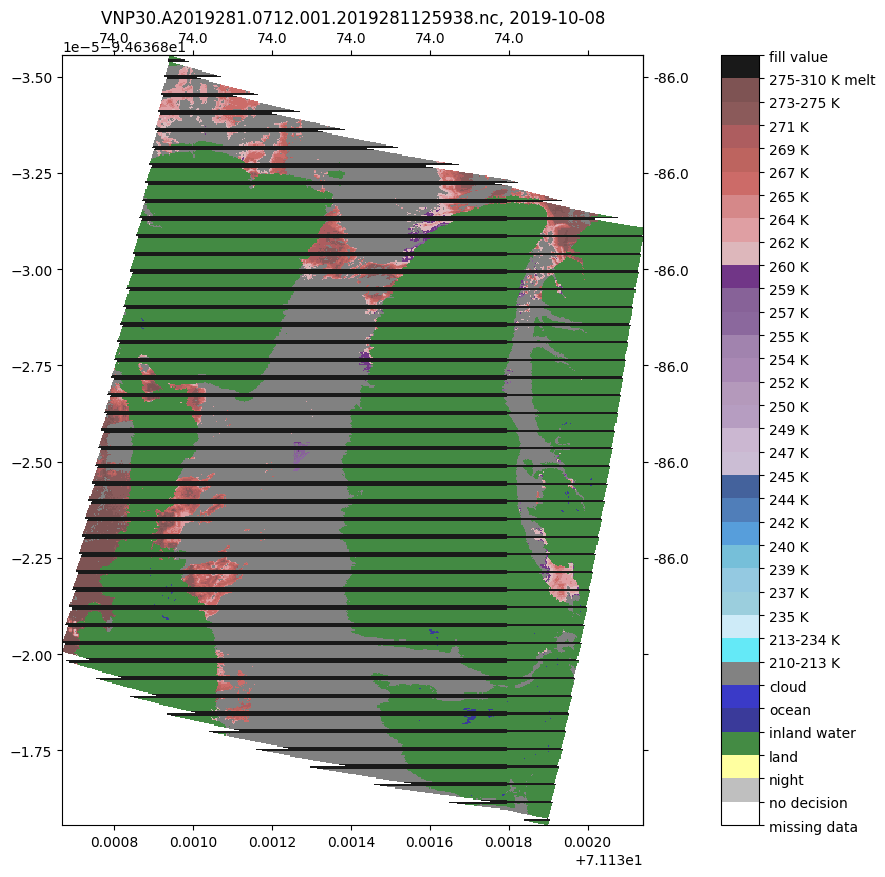

Verify IST values: [  3.   4.   6.  33. 255. 256. 257. 258. 259. 260. 261. 262. 263. 264.
 265. 266. 267. 268. 269. 270. 271. 272. 273. 274.  nan]
% Ice [< 271 K]: 4.7608561112018135
% Thick Ice [<260 K]: 0.36069968144522874
<xarray.Dataset>
Dimensions:  (x: 697, y: 551)
Dimensions without coordinates: x, y
Data variables:
    IST      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lon      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lat      (x, y) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    description:  VIIRS ice surface temperature, latitude, and longitude data.
Verify discrete IST values: [ 3.  4.  6. 22. 23. 24. 25. 26. 27. 28. 29. 30. 33. nan]
Plotting: VNP30.A2019281.1030.001.2019281162217.nc


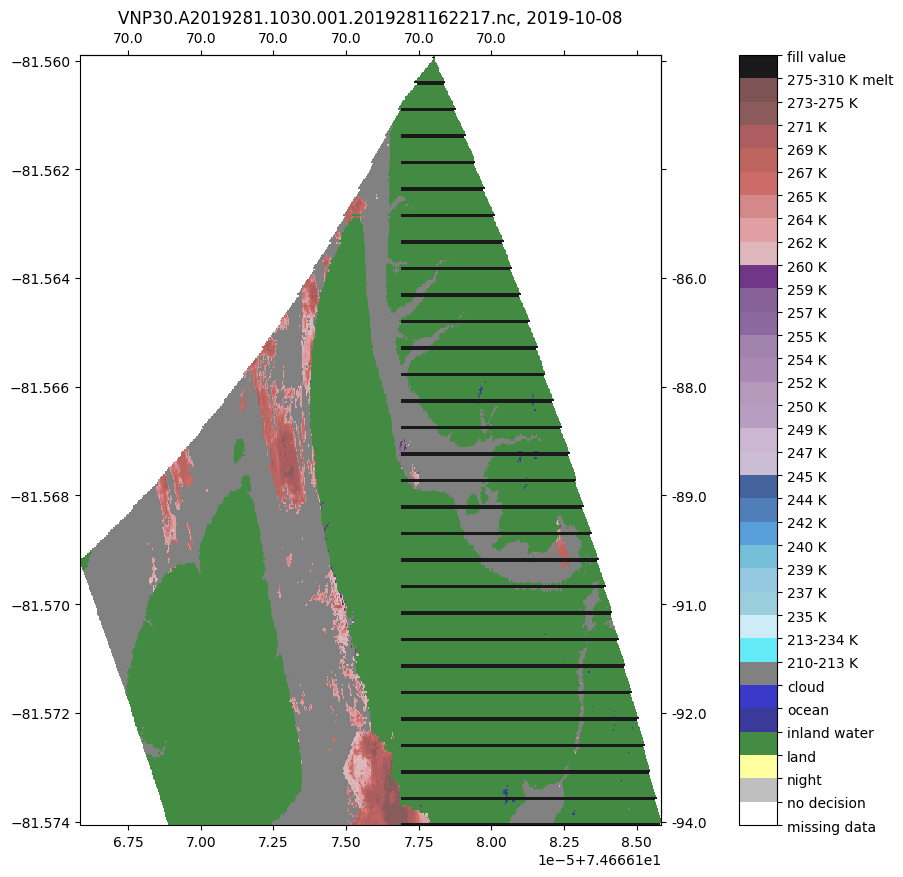

Verify IST values: [  3.   4.   6.  33. 257. 258. 259. 260. 261. 262. 263. 264. 265. 266.
 267. 268. 269. 270. 271. 272.  nan]
% Ice [< 271 K]: 5.598126862494678
% Thick Ice [<260 K]: 0.1058022187163499
<xarray.Dataset>
Dimensions:  (x: 465, y: 599)
Dimensions without coordinates: x, y
Data variables:
    IST      (x, y) float32 nan nan nan nan nan nan ... 33.0 33.0 33.0 nan nan
    lon      (x, y) float32 nan nan nan nan nan ... -86.04 -86.02 -86.0 nan nan
    lat      (x, y) float32 nan nan nan nan nan ... 70.19 70.18 70.17 nan nan
Attributes:
    description:  VIIRS ice surface temperature, latitude, and longitude data.


In [ ]:
print("PLOT EACH COMPATIBLE VIIRS FILE\n")
plot_segment = True
best_viirs_file = format_VIIRS(path_viirs, path_sentinel, compatible_files, common_latitudes, common_longitudes, plot_segment)
print(f'The best file is: {best_viirs_file}')

In [ ]:
### Load the Sentinel-1 trial file ###
Sentinel_data = load_Sentinel(sentinel_filepath + sentinel_filename)
### Load the Sentinel-1 trial file ###

viirs_file = VIIRS_filepath + best_viirs_file

interpolated_nc, dim_x, dim_y = format_Sentinel(Sentinel_data, sentinel_filepath, best_viirs_file, compatible_files, common_latitudes, common_longitudes, percent_overlap)
add_dims_xml(trial_filename_xml, viirs_file, dim_x, dim_y)

OVERLAP < 100 [%]: 89.68679893247263


Run cell if you need to delete files only (usually before filtering the next batch of VIIRS scenes)

In [ ]:
# Specify the folder path
folder_path = '/content/VIIRS_data'

# Call the function to delete all files in the folder
delete_all_files_in_folder(folder_path)

All files in the folder '/content/VIIRS_data' have been deleted.
